In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

/Applications/anaconda3/envs/py10/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
# Define the LSTM Autoencoder model
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)
    
    def forward(self, x):
        # Encoder
        encoded, (hidden, cell) = self.encoder(x)
        # Decoder
        decoded, _ = self.decoder(encoded)  # Pass the encoded representation through the decoder
        return decoded

In [3]:
# Load and preprocess data
df = pd.read_csv('data/GE.csv')  # Load the file
df = df[['Date', 'Close']]  # Only use Date and Close columns
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
# Split data into train and test sets
train, test = df.loc[df['Date'] <= '2013-09-03'], df.loc[df['Date'] > '2013-09-03']

In [5]:
# Normalize the Close price
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])
train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/var/folders/rk/wm0jqkg16wgg146w5t5kkx340000gn/T/ipykernel_71567/1556226665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
/var/folders/rk/wm0jqkg16wgg146w5t5kkx340000gn/T/ipykernel_71567/1556226665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [6]:
# Define function to create sequences
TIME_STEPS = 30
def create_sequences(data, time_steps=TIME_STEPS):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
    return np.array(sequences)

In [7]:
# Create sequences from training and testing data
X_train = create_sequences(train['Close'].values)
X_test = create_sequences(test['Close'].values)

In [8]:
# Convert data to PyTorch tensors and reshape to (batch_size, time_steps, input_dim)
X_train_tensors = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Shape: (num_samples, time_steps, 1)
X_test_tensors = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)    # Shape: (num_samples, time_steps, 1)

In [23]:
# Model parameters
input_dim = 1  # We have 1 feature ('Close' price)
hidden_dim = 128  # Number of hidden units in the LSTM
num_layers = 1  # Number of LSTM layers
num_epochs = 100
batch_size = 16
learning_rate = 0.001

In [24]:
# Instantiate the model
model = LSTMAutoencoder(input_dim, hidden_dim, num_layers)

In [25]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensors)
    loss = criterion(outputs, X_train_tensors)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.4946
Epoch [20/100], Loss: 0.2206
Epoch [30/100], Loss: 0.1936
Epoch [40/100], Loss: 0.1650
Epoch [50/100], Loss: 0.1529
Epoch [60/100], Loss: 0.1433
Epoch [70/100], Loss: 0.1360
Epoch [80/100], Loss: 0.1314
Epoch [90/100], Loss: 0.1280
Epoch [100/100], Loss: 0.1256


In [27]:
# Evaluation: Calculate training MAE loss
model.eval()
with torch.no_grad():
    X_train_pred = model(X_train_tensors)
    train_mae_loss = torch.mean(torch.abs(X_train_pred - X_train_tensors), dim=1).numpy()

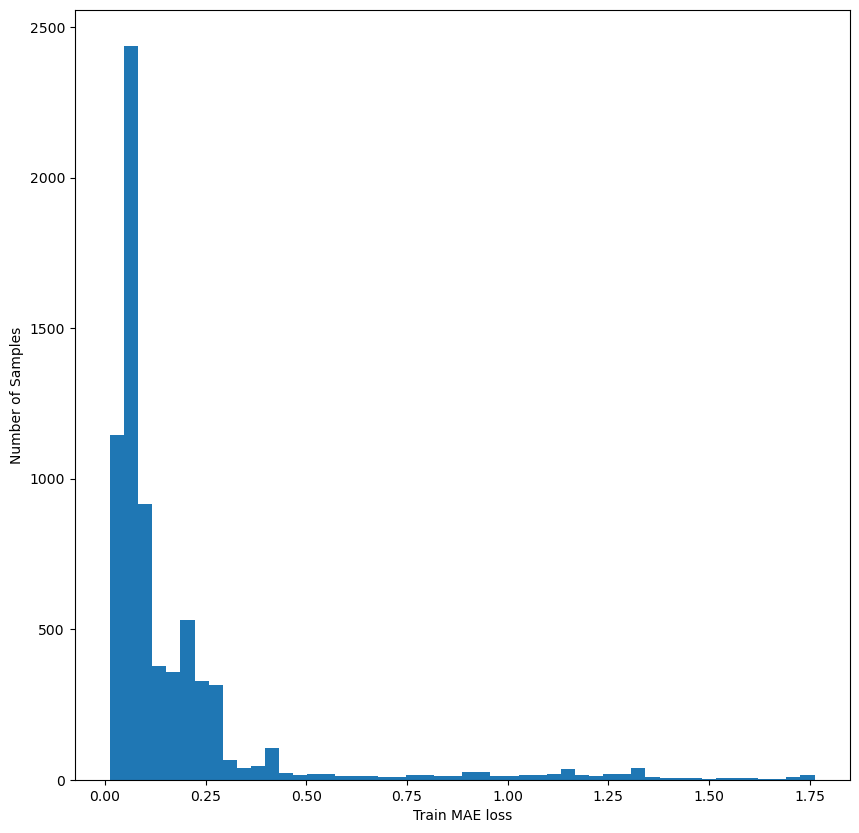

In [28]:
# Plotting train MAE loss
plt.figure(figsize=(10,10))
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [29]:
# Set anomaly detection threshold
threshold = np.percentile(train_mae_loss, 85)
print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 0.2650650292634964


In [30]:
# Test data predictions and anomaly detection
with torch.no_grad():
    X_test_pred = model(X_test_tensors)
    test_mae_loss = torch.mean(torch.abs(X_test_pred - X_test_tensors), dim=1).numpy()

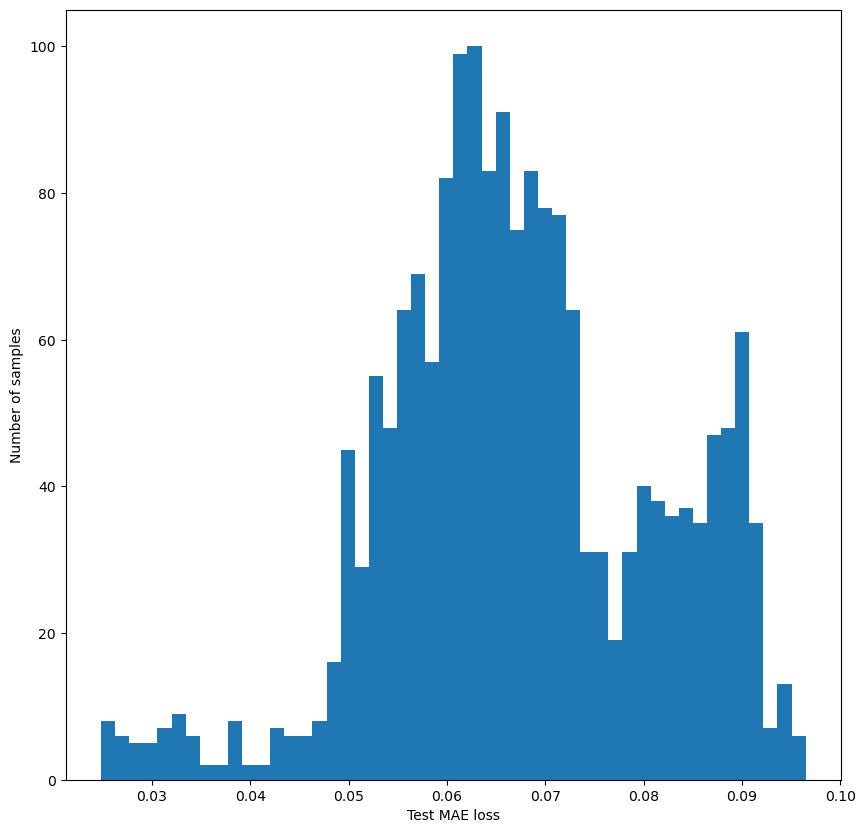

In [31]:
# Plot test MAE loss
plt.figure(figsize=(10,10))
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')
plt.show()

In [38]:
import plotly.graph_objects as go

# Set anomaly detection threshold based on the training loss
threshold = np.percentile(train_mae_loss, 50)
print(f'Reconstruction error threshold: {threshold}')

# Test data predictions and anomaly detection
with torch.no_grad():
    X_test_pred = model(X_test_tensors)
    test_mae_loss = torch.mean(torch.abs(X_test_pred - X_test_tensors), dim=1).numpy()

# Create DataFrame for test scores
test_score_df = pd.DataFrame(test[TIME_STEPS:]).reset_index(drop=True)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = scaler.inverse_transform(test[TIME_STEPS:]['Close'].values.reshape(-1, 1))

# Plot test MAE loss and threshold using plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

# Visualize anomalies on the actual Close price
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['Close'], name='Close price'))
fig.add_trace(go.Scatter(x=test_score_df.loc[test_score_df['anomaly'], 'Date'], 
                         y=test_score_df.loc[test_score_df['anomaly'], 'Close'], 
                         mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies in Close price')
fig.show()


Reconstruction error threshold: 0.08275258541107178
